In [5]:
import pandas as pd
from google.colab import files
import io
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [4]:
uploaded = files.upload()

Saving news.csv to news.csv


In [31]:
df = pd.read_csv(io.BytesIO(uploaded['news.csv']))

In [32]:
print(df.columns)
df["label"].replace({"REAL": 1, "FAKE": 0}, inplace=True)
y = df.iloc[:, -1]
df["new_text"] = df["title"] + df["text"]
X = df.iloc[:, -1]
print(y.value_counts(normalize=True))
X = np.array(X)
y = np.array(y)
#print(X)
#print(y)

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')
1    0.500552
0    0.499448
Name: label, dtype: float64


In [8]:
def length_dicsarding_space(text):
    return len(text) - text.count(' ')

In [9]:
max_features = 10000
#sequence_length = max(list(map(length_dicsarding_space, X)))
sequence_length = 25000
print(sequence_length)

25000


In [10]:
vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [11]:
vectorize_layer.adapt(X)

print(vectorize_layer(X[0]))

tf.Tensor([  39   64 8936 ...    0    0    0], shape=(25000,), dtype=int64)


In [12]:
vectorized_text = vectorize_layer(X)
#print(vectorized_text)
vectorized_text = np.array(vectorized_text)
print(vectorized_text.shape)

(6335, 25000)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(vectorized_text, y, test_size=.33, random_state=4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.33, random_state=42)

In [14]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(4244, 25000)
(1400, 25000)
(691, 25000)
(4244,)
(1400,)
(691,)


In [15]:
embedding_dim = 16

In [16]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

In [17]:
model.compile(loss=tf.losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy())

In [18]:
epochs = 80
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs)

Epoch 1/80
133/133 [==============================] - 34s 242ms/step - loss: 0.8493 - binary_accuracy: 0.5035 - val_loss: 0.7051 - val_binary_accuracy: 0.4921
Epoch 2/80
133/133 [==============================] - 33s 245ms/step - loss: 0.7037 - binary_accuracy: 0.5021 - val_loss: 0.6925 - val_binary_accuracy: 0.4950
Epoch 3/80
133/133 [==============================] - 31s 234ms/step - loss: 0.7003 - binary_accuracy: 0.5061 - val_loss: 0.6903 - val_binary_accuracy: 0.6886
Epoch 4/80
133/133 [==============================] - 30s 229ms/step - loss: 0.6957 - binary_accuracy: 0.5229 - val_loss: 0.6885 - val_binary_accuracy: 0.5171
Epoch 5/80
133/133 [==============================] - 30s 224ms/step - loss: 0.6934 - binary_accuracy: 0.5181 - val_loss: 0.6861 - val_binary_accuracy: 0.5621
Epoch 6/80
133/133 [==============================] - 29s 221ms/step - loss: 0.6925 - binary_accuracy: 0.5252 - val_loss: 0.6827 - val_binary_accuracy: 0.6971
Epoch 7/80
133/133 [==========================

In [19]:
loss, accuracy = model.evaluate(X_test, y_test)
print(loss)
print(accuracy)

22/22 [==============================] - 1s 29ms/step - loss: 0.3494 - binary_accuracy: 0.8423
0.3493648171424866
0.8422576189041138


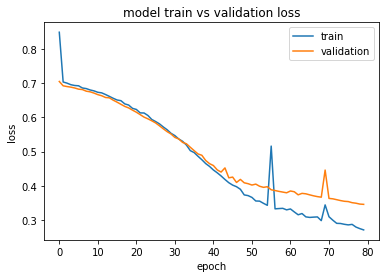

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

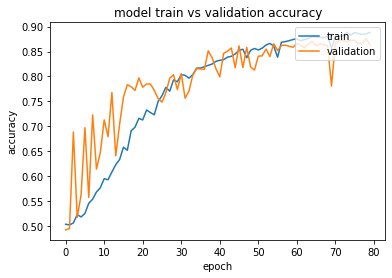

In [27]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')